In [33]:
from brainrender.atlas_specific import GeneExpressionAPI
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from tqdm import tqdm

%matplotlib widget

In [34]:
geapi = GeneExpressionAPI()
gene_info = geapi.get_all_genes()
gene_info.head()

,id,gene_symbol,gene_name,entrez_gene_id,homologene_group_id
0,158383,1700010L04Rik,RIKEN cDNA 1700010L04 gene,619808,None
1,46574,6330411E07Rik,RIKEN cDNA 6330411E07 gene,70733,None
2,106388,6330581N18Rik,RIKEN cDNA 6330581N18 gene,319453,None
3,106517,6430573F11Rik,RIKEN cDNA 6430573F11 gene,319582,35306
4,87409,A2m,alpha-2-macroglobulin,232345,37248


In [35]:
gene = "Pcp4"
expids = geapi.get_gene_experiments(gene)
data = geapi.get_gene_data(gene=gene,  exp_id=expids[0])

In [36]:
data_dims = data.shape
xs, zs, ys = [np.arange(data_dims[i]) for i in range(3)]

coords = np.array(np.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
outcome = np.array([data[c[0], c[2], c[1]] for c in coords])
assert len(outcome) == len(coords)

In [39]:
observed_idx = np.where(outcome > 2)
coords = coords[observed_idx]
coords[:, 2] = np.max(coords[:, 2]) - coords[:, 2]
outcome = outcome[observed_idx]

coords = coords.astype(np.float64)
coords -= coords.mean(0)

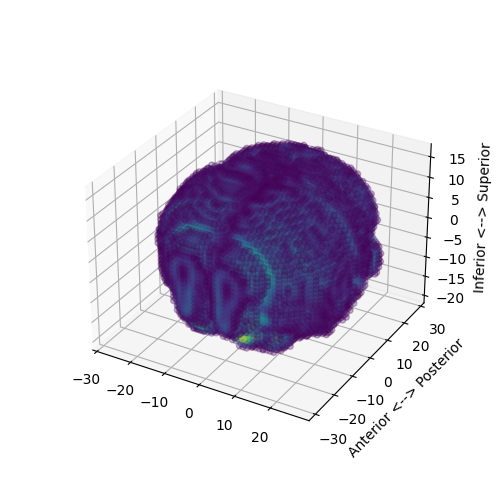

In [40]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=outcome, alpha=0.3)

# ax.set_xlabel("x")
ax.set_ylabel("Anterior <--> Posterior", rotation=90)
ax.set_zlabel("Inferior <--> Superior", rotation=90)

plt.savefig("./out/aba_brain_3d.png")

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

plt.show()

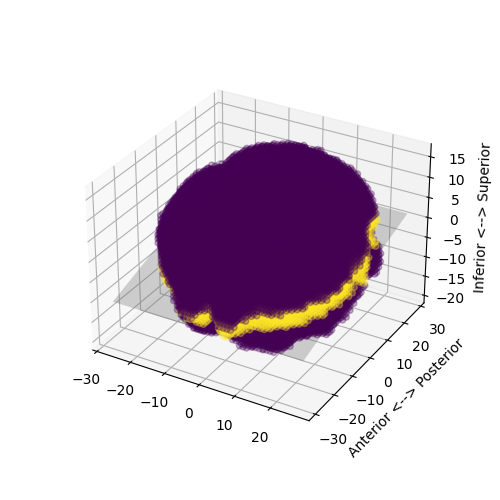

In [53]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

CLOSE_DIST = 2

P = np.array([0, -1, 4.7, 20])
# P = np.array([1, -1, 0, 0])

dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))

ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=dists < CLOSE_DIST, alpha=0.3) #, s=5)

# xx, yy = np.meshgrid(range(np.max(coords[:, 0])), range(np.max(coords[:, 1])))
xx, yy = np.meshgrid(
    np.linspace(np.min(coords[:, 0]), np.max(coords[:, 0]), 10),
    np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), 10),
)
z = (P[0] * xx + P[1] * yy + P[3]) / -P[2]
ax.plot_surface(xx, yy, z, color="gray", alpha=0.3)



ax.set_ylabel("Anterior <--> Posterior", rotation=90)
ax.set_zlabel("Inferior <--> Superior", rotation=90)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

plt.savefig("./out/aba_example_slice.png")

plt.show()

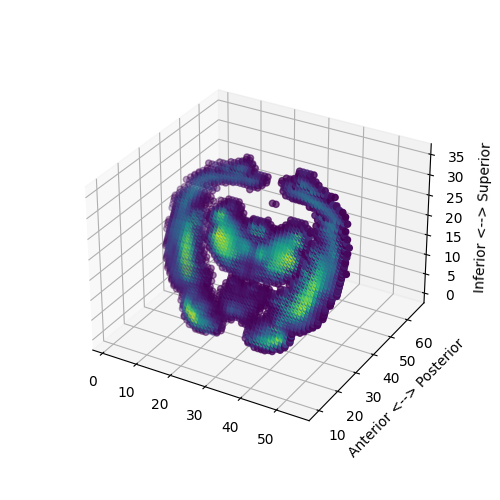

In [23]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

close_idx = np.where(dists < CLOSE_DIST)


normal_vector = P[:3] / np.linalg.norm(P[:3], ord=2)
dists_signed = (P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
projected_points = coords[close_idx] - (dists_signed[close_idx] * normal_vector.reshape(-1, 1)).T

projected_point_dists = np.abs(P[0] * projected_points[:, 0] + P[1] * projected_points[:, 1] + P[2] * projected_points[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
assert np.allclose(projected_point_dists, 0)

ax.scatter3D(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], c=outcome[close_idx])
# ax.scatter3D(coords[close_idx][:, 0], coords[close_idx][:, 1], coords[close_idx][:, 2])



ax.set_ylabel("Anterior <--> Posterior", rotation=90)
ax.set_zlabel("Inferior <--> Superior", rotation=90)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

plt.savefig("./out/aba_example_resulting_slice.png")

plt.show()

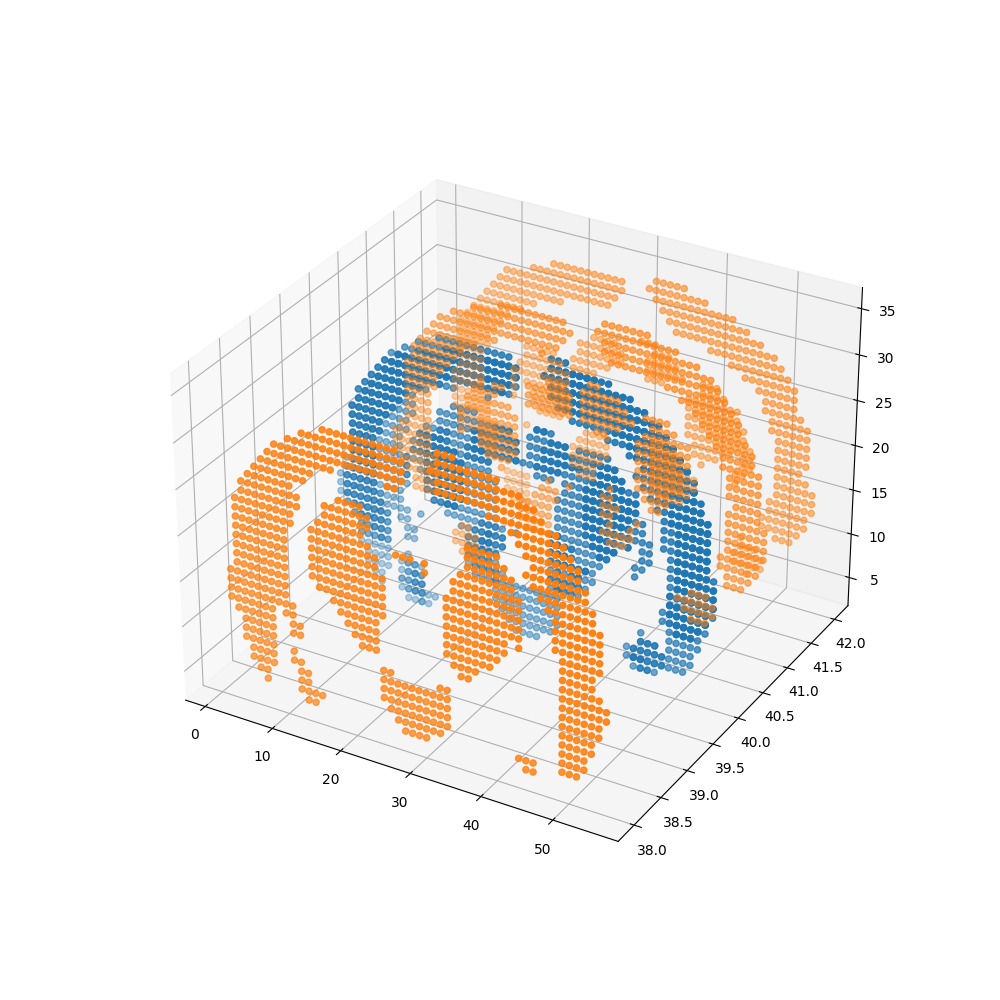

In [11]:
P = np.array([0, -1, 0, 40])
dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))
close_idx = np.where(dists < 3)


normal_vector = P[:3] / np.linalg.norm(P[:3], ord=2)
dists_signed = (P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
projected_points = coords[close_idx] - (dists_signed[close_idx] * normal_vector.reshape(-1, 1)).T

projected_point_dists = np.abs(P[0] * projected_points[:, 0] + P[1] * projected_points[:, 1] + P[2] * projected_points[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
assert np.allclose(projected_point_dists, 0)

plt.close()
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2])
ax.scatter3D(coords[close_idx][:, 0], coords[close_idx][:, 1], coords[close_idx][:, 2])

plt.show()

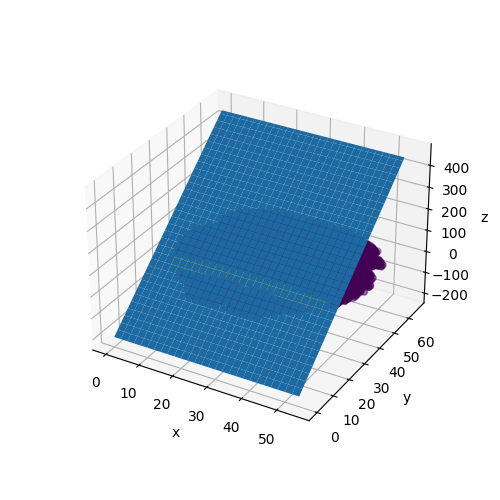

In [15]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

P = np.array([0, -1, 0.1, 20])

dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))
ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=dists < 3, alpha=0.3)

xx, yy = np.meshgrid(range(np.max(coords[:, 0])), range(np.max(coords[:, 1])))
z = (P[0] * xx + P[1] * yy + P[3]) / -P[2]
ax.plot_surface(xx, yy, z)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

In [13]:
kernel = RBF()

y_slices = np.arange(np.min(coords[:, 1]), 40) #np.max(coords[:, 1]))
eigs = np.zeros(len(y_slices))
dist_threshold = 3

for ii, yslice in enumerate(y_slices):
    
    # Define plane
    P = np.array([0, -1, 0, yslice])
    
    # Find points observed by this slice
    dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))
    close_idx = np.where(dists <= dist_threshold)

    normal_vector = P[:3] / np.linalg.norm(P[:3], ord=2)
    dists_signed = (P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
    projected_points = coords[close_idx] - (dists_signed[close_idx] * normal_vector.reshape(-1, 1)).T
    
    # Ensure that projection worked
    projected_point_dists = np.abs(P[0] * projected_points[:, 0] + P[1] * projected_points[:, 1] + P[2] * projected_points[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
    assert np.allclose(projected_point_dists, 0)
    
    # Compute EIG
    cov = kernel(projected_points)
    noise_variance = 1e-2
    eig = 0.5 * np.linalg.slogdet(1 / noise_variance * cov + np.eye(len(projected_points)))[
        1
    ]
    eigs[ii] = eig

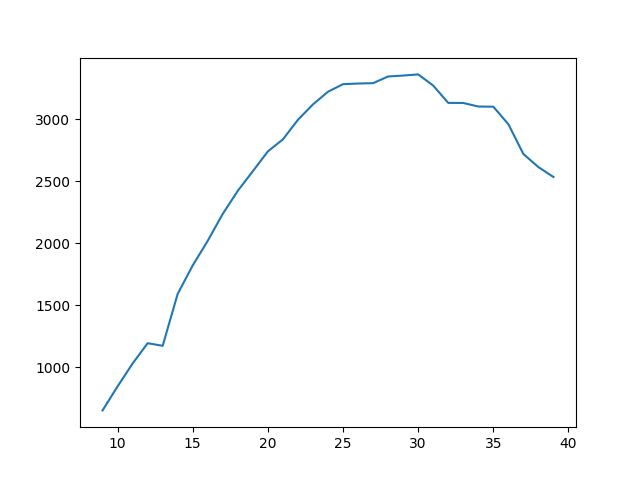

In [14]:
plt.close()
plt.plot(y_slices, eigs)
plt.show()